# Model Evaluation

Use the best model from the experiments to estimate generalization performance on the test set.

In [1]:
%load_ext autoreload
%autoreload 2

from utils import code

In [2]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from support.model import Model
from support.datasets import get_data
from support.experiments import get_auc_scorer
from support.experiments.experiment_1 import CATEGORICAL_FEATURES, baseline_model_predictions
from support.parameters import P_TARGETED, AVG_COST, AVG_REVENUE

%matplotlib inline

## Model

Load the best performing model

In [3]:
tuned_model = Model.load('../models/experiment-1-model.pkl')
model = Model(tuned_model.name, tuned_model.model, tuned_model.pipeline)

Load the training and test sets

In [4]:
X_train, y_train = get_data('../data/train.csv')
X_test, y_test = get_data('../data/test.csv')

In [7]:
X_train.loc[X_train.job.isin(['retired', 'student', 'unemployed']), 'job'] = 'rare_high_prob'
X_test.loc[X_test.job.isin(['retired', 'student', 'unemployed']), 'job'] = 'rare_high_prob'

X_train.loc[X_train.month.isin(['mar', 'oct', 'dec', 'sep']), 'month'] = 'rare_high_prob'
X_test.loc[X_test.month.isin(['mar', 'oct', 'dec', 'sep']), 'month'] = 'rare_high_prob'

X_train.loc[X_train.poutcome.isin(['failure', 'nonexistent']), 'poutcome'] = 'failure'
X_test.loc[X_test.poutcome.isin(['failure', 'nonexistent']), 'poutcome'] = 'failure'

In [8]:
print('Number of training instances: {:,}'.format(len(X_train)))
print('Number of test instances: {:,}'.format(len(X_test)))

Number of training instances: 32,950
Number of test instances: 8,238


Build the model using the training set

In [9]:
model.train(X_train, y_train)

## Model Performance

In [10]:
n_targeted = int(len(X_test) * P_TARGETED)
print('Number of targeted customers:', n_targeted)

Number of targeted customers: 543


Predict and score the test set

In [12]:
scorer = get_auc_scorer()
model.score(X_test, y_test, scorer)

0.6590775213453465

AUC improved by ~0.02 - how much does this affect other metrics?

## Financial Performance

Evaluate financial performance on baseline

In [20]:
baseline_preds = baseline_model_predictions(X_test, y_test, n_targeted)
baseline_outcomes = baseline_preds.apply(lambda x: AVG_COST if x == 0 else AVG_COST + AVG_REVENUE)
baseline_profit = sum(baseline_outcomes)
baseline_conv_rate = baseline_preds.sum() / len(baseline_preds)
base_rate = y_test.sum() / len(y_test)

print('Baseline profit: ${:,}'.format(baseline_profit))
print('Baseline conversion rate: {:.2f}'.format(baseline_conv_rate))
print('Lift over random model: {:.1f}'.format(baseline_conv_rate / base_rate))

Baseline profit: $227,418
Baseline conversion rate: 0.39
Lift over random model: 3.5


In [21]:
X_test_trans = model.pipeline.transform(X_test)
preds = model.model.predict(X_test_trans)
probs = model.model.predict_proba(X_test_trans)

In [22]:
# Create a dataframe of probabilities and actual / predicted outcomes
probs_df = pd.DataFrame(np.hstack([probs, y_test.values.reshape(-1,1), preds.reshape(-1,1)]), columns=['p_no', 'p_yes', 'actual', 'predicted'])

# Sort customers by the probability that they will convert
model_targets = probs_df.sort_values('p_yes', ascending=False)

# Take the top N
model_targets = model_targets.head(n_targeted)

# Calculate financial outcomes
model_outcomes = model_targets.actual.apply(lambda x: AVG_COST if x == 0 else AVG_COST + AVG_REVENUE)
model_profit = sum(model_outcomes)
model_conv_rate = model_targets.actual.sum() / len(model_targets)

model_profit_lift_baseline = model_profit / baseline_profit, model_profit - baseline_profit
model_conv_lift_baseline = model_conv_rate / baseline_conv_rate

print('Model profit: ${:,}'.format(model_profit))
print('Model lift over basline profit: {:.1f} or ${:,}'.format(model_profit_lift_baseline[0] ,model_profit_lift_baseline[1]))
print('Targeted conversion rate: {:.2f}'.format(model_conv_rate))
print('Conversion rate lift over baseline: {:.2f}'.format(model_conv_lift_baseline))

Model profit: $316,224
Model lift over basline profit: 1.4 or $88,806
Targeted conversion rate: 0.55
Conversion rate lift over baseline: 1.38


A lift of 4% w.r.t. conversion rate and \$19.4K w.r.t. financial impact.

In [19]:
print(classification_report(model_targets.actual, model_targets.predicted))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       247
         1.0       0.55      1.00      0.71       296

   micro avg       0.55      0.55      0.55       543
   macro avg       0.27      0.50      0.35       543
weighted avg       0.30      0.55      0.38       543



/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision improved by 4%.

Given the neglible cost of false negatives, we can afford to miss all of the true negatives in the targeted sample - customers who did not end up converting.

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


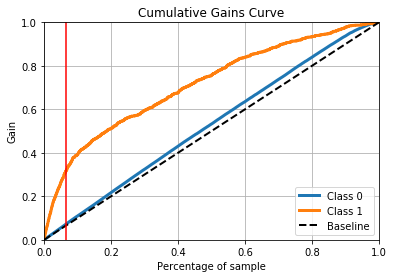

In [26]:
skplt.metrics.plot_cumulative_gain(y_test, probs);
plt.axvline(.066, color='red');

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


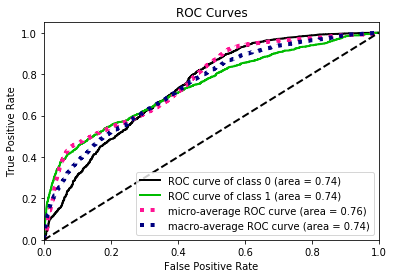

In [27]:
skplt.metrics.plot_roc_curve(y_test, probs);
# plt.axvline(.066, color='red');